In [1]:
# Import data
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from functions import *
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm 
import sqlite3
import os

X_used, Y = get_data(42)
n = X_used.shape[0]

grid_size = 50
a_grid = np.linspace(np.min(X_used.age), np.max(X_used.age), grid_size)
w_grid = np.linspace(np.min(X_used.hh_inc), np.max(X_used.hh_inc), grid_size)
xv, wv = np.meshgrid(a_grid, w_grid, indexing='ij')

X_used_cnst = sm.add_constant(X_used)
model = sm.OLS(Y,X_used_cnst)
results = model.fit()
# results.summary()

CV_grid_n = 20
seed = 46

In [2]:
# Make Database
database_name = 'database_happiness_NP.db'
con = sqlite3.connect(os.path.join('Results', database_name))
cur = con.cursor()

res = cur.execute("""SELECT name FROM sqlite_master WHERE type='table'""")
table_names = res.fetchall()
if ~np.isin('CV_Error', table_names):
    print("CREATE NEW DATABASE TABLE")
    str_append = ''
    for s in np.arange(1,CV_grid_n+1):
        str_append = str_append+'col_%i REAL NOT NULL, '%s

    cur.execute("""CREATE TABLE IF NOT EXISTS CV_Error(
                Model TEXT NOT NULL,
                Tune_Param TEXT NOT NULL,
                Seed INTEGER NOT NULL,"""\
                + str_append\
                + """PRIMARY KEY (Model, Tune_Param, Seed))""")
    con.commit()
else:
    print("DATABASE TABLE ALREADY EXISTS")
    con.commit()

DATABASE TABLE ALREADY EXISTS


In [3]:
# Get max_depth parameter using cross validation
n_estimators = 500
max_depth_list = np.append(np.linspace(1,50,CV_grid_n-1).astype(int),None)
fold_size = 5
t = time.time()
CV_error_RF = np.zeros((len(max_depth_list),))
for i,max_depth in enumerate(max_depth_list):
    RF_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=seed)
    scores = cross_val_score(RF_model, X_used, Y, cv=fold_size, scoring='neg_mean_squared_error', n_jobs=fold_size)
    CV_error_RF[i] = -np.mean(scores)
elapsed = time.time() - t
print('elapsed time = %0.2f sec; %s'%(elapsed, datetime.datetime.now()))


elapsed time = 901.21 sec; 2024-08-22 09:38:27.666857


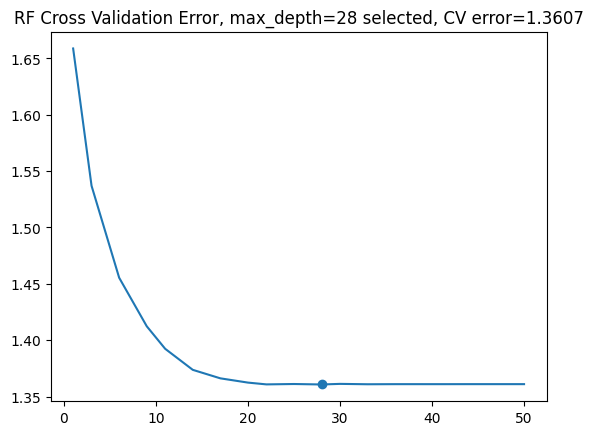

In [4]:
temp_grid = ['None' if x==None else x for x in max_depth_list]
RF_out = {'Model':['Random Forest']*2,
          'Tune_Param': ['CV_grid','max_depth'],
          'Seed':[seed]*2}
col_names = ['col_%i'%i for i in range(1,CV_grid_n+1)] 
for i,cn in enumerate(col_names):
    RF_out[cn] = [temp_grid[i], CV_error_RF[i]]

RF_out = pd.DataFrame(RF_out)

idx = CV_error_RF.argmin()
plt.figure()
plt.plot(max_depth_list, CV_error_RF)
plt.scatter(max_depth_list[idx], CV_error_RF[idx])
plt.title('RF Cross Validation Error, max_depth=%i selected, CV error=%0.4f'%(temp_grid[idx],CV_error_RF[idx]))
# plt.savefig('Figures/RF_validation.png')
plt.show()

In [5]:
t = time.time()
n_estimators_list = np.linspace(1,200,CV_grid_n).astype(int)
CV_error_XGB = np.zeros((len(n_estimators_list),))
for i,n_estimators in enumerate(n_estimators_list):
    # print(n_est)
    XGB_model = xgb.XGBRegressor(n_jobs=1, tree_method="exact", n_estimators=n_estimators, random_state=seed)
    scores = cross_val_score(XGB_model, X_used, Y, cv=fold_size, scoring='neg_mean_squared_error', n_jobs=fold_size)
    CV_error_XGB[i] = -np.mean(scores)
elapsed = time.time() - t
print('elapsed time = %0.2f sec; %s'%(elapsed, datetime.datetime.now()))

elapsed time = 46.45 sec; 2024-08-22 09:39:14.292785


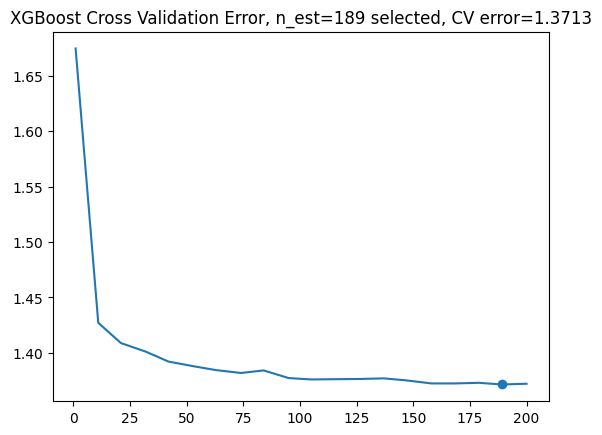

In [6]:

XGB_out = {'Model':['XGBoost']*2,
          'Tune_Param': ['CV_grid','n_estimators'],
          'Seed':[seed]*2}
col_names = ['col_%i'%i for i in range(1,CV_grid_n+1)] 
for i,cn in enumerate(col_names):
    XGB_out[cn] = [n_estimators_list[i], CV_error_XGB[i]]

XGB_out = pd.DataFrame(XGB_out)

idx = CV_error_XGB.argmin()
plt.figure()
plt.plot(n_estimators_list, CV_error_XGB)
plt.scatter(n_estimators_list[idx],CV_error_XGB[idx])
plt.title('XGBoost Cross Validation Error, n_est=%i selected, CV error=%0.4f'%(n_estimators_list[idx],CV_error_XGB[idx]))
plt.show()
# plt.savefig('Figures/XGB_validation.png')


In [7]:
num_parallel_tree = 100
subsample = np.sqrt(X_used.shape[0])/X_used.shape[0]
t = time.time()
n_estimators_list = np.linspace(1,70,CV_grid_n).astype(int)
CV_error_XGBs = np.zeros((len(n_estimators_list),))
for i,n_estimators in enumerate(n_estimators_list):
    # print(n_est)
    XGBs_model = xgb.XGBRegressor(n_jobs=1, tree_method="exact", n_estimators=n_estimators,
                           num_parallel_tree = num_parallel_tree, subsample = subsample, random_state=seed)
    scores = cross_val_score(XGBs_model, X_used, Y, cv=fold_size, scoring='neg_mean_squared_error', n_jobs=fold_size)
    CV_error_XGBs[i] = -np.mean(scores)
elapsed = time.time() - t
print('elapsed time = %0.2f sec; %s'%(elapsed, datetime.datetime.now()))

elapsed time = 775.06 sec; 2024-08-22 09:52:09.532487


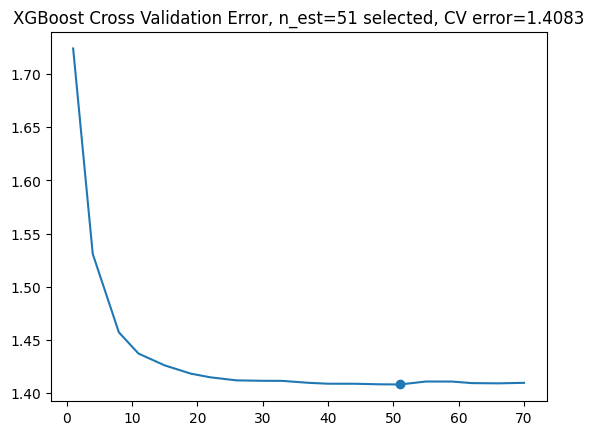

In [8]:

XGBs_out = {'Model':['XGBoost-subsample']*2,
          'Tune_Param': ['CV_grid','n_estimators'],
          'Seed':[seed]*2}
col_names = ['col_%i'%i for i in range(1,CV_grid_n+1)] 
for i,cn in enumerate(col_names):
    XGBs_out[cn] = [n_estimators_list[i], CV_error_XGBs[i]]

XGBs_out = pd.DataFrame(XGBs_out)

idx = CV_error_XGBs.argmin()
plt.figure()
plt.plot(n_estimators_list, CV_error_XGBs)
plt.scatter(n_estimators_list[idx],CV_error_XGBs[idx])
plt.title('XGBoost Cross Validation Error, n_est=%i selected, CV error=%0.4f'%(n_estimators_list[idx],CV_error_XGBs[idx]))
plt.show()
# plt.savefig('Figures/XGB_validation.png')


In [11]:
out

array([['Random Forest', 'CV_grid', 46, 1.0, 3.0, 6.0, 9.0, 11.0, 14.0,
        17.0, 20.0, 22.0, 25.0, 28.0, 30.0, 33.0, 36.0, 39.0, 41.0, 44.0,
        47.0, 50.0, 'None'],
       ['Random Forest', 'max_depth', 46, 1.6588714772862108,
        1.5370093851075342, 1.4554332106230021, 1.4123273933614295,
        1.3923524061213612, 1.373671773354164, 1.3661241225780487,
        1.3623436206068267, 1.3607628533028697, 1.3610960710305458,
        1.3606820889238136, 1.3612129738346372, 1.3608775031387847,
        1.360965491309559, 1.3609604716353279, 1.3609552124612811,
        1.36097754762709, 1.36097754762709, 1.36097754762709,
        1.36097754762709],
       ['XGBoost', 'CV_grid', 46, 1.0, 11.0, 21.0, 32.0, 42.0, 53.0,
        63.0, 74.0, 84.0, 95.0, 105.0, 116.0, 126.0, 137.0, 147.0, 158.0,
        168.0, 179.0, 189.0, 200.0],
       ['XGBoost', 'n_estimators', 46, 1.674819144954709,
        1.427015306437458, 1.4087041252610977, 1.400929483933734,
        1.3919829545398918, 1.38

In [9]:
out = pd.concat((RF_out,XGB_out,XGBs_out),axis=0).values

str_append = ''
for s in np.arange(1,CV_grid_n+1):
    str_append = str_append+', col_%i'%s

s = ','.join(['?']*(CV_grid_n+3))
query = "insert or replace into CV_Error (Model, Tune_Param, Seed"+str_append+") values ("+ s+ ")"

cur.executemany(query, out)
con.commit()
cur.close()
con.close()

In [13]:
str_append = ''
for s in np.arange(1,CV_grid_n+1):
    str_append = str_append+', col_%i'%s

s = ','.join(['?']*(CV_grid_n+3))
query = "insert or replace into CV_Error (Model, Tune_Param, Seed"+str_append+") values ("+ s+ ")"
query

'insert or replace into CV_Error (Model, Tune_Param, Seed, col_1, col_2, col_3, col_4, col_5, col_6, col_7, col_8, col_9, col_10, col_11, col_12, col_13, col_14, col_15, col_16, col_17, col_18, col_19, col_20) values (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)'